In [1]:
import utm
import math
import numpy as np
import pandas as pd
import re
import geopandas as gpd
import random
import scipy.io as sio
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

In [2]:
df =  pd.read_csv(r"E:\Usuário\Pablo\Documents\MEGAsync\Trabalhos hidrologia\medições de vazao\Brilhante\20220607121313.sum", encoding='windows-1252')  
df_matlab = sio.loadmat(r"E:\Usuário\Pablo\Documents\MEGAsync\Trabalhos hidrologia\medições de vazao\Brilhante\20220607121313.mat")
df_utm = pd.DataFrame({'utm_x' : [x[0] for x in df_matlab['GPS'][0][-1][-2]], 'utm_y' : [x[1] for x in df_matlab['GPS'][0][-1][-2]]})
velocidades = pd.read_csv(r"E:\Usuário\Pablo\Documents\MEGAsync\Trabalhos hidrologia\medições de vazao\Brilhante\20220607121313.vel", encoding='windows-1252')

nome_salvamento = 'brilhante' + '20220607121313'

In [4]:
 df['zscore_direction'] = ((df['Direction (deg)'].mean() - df['Direction (deg)']))/df['Direction (deg)'].std()

In [5]:
#Separando coordenadas x e y
utm_x = df_utm['utm_x']
utm_y = df_utm['utm_y']

#Separando as componentes de velocidade. 

name_velx = []
name_vely = []
name_velz = []


for nomex in velocidades.columns:
    if re.search(r'Ve', nomex) != None:
        name_velx.append(nomex)
        
for nomey in velocidades.columns:
    if re.search(r'Vn', nomey) != None:
        name_vely.append(nomey)
        
for namez in velocidades.columns:
    if re.search(r'Vu', namez) != None:
        name_velz.append(namez)

#Coponentes de interesse.        
        
velocidade_x = velocidades[name_velx]
velocidade_y = velocidades[name_vely]
velocidade_z = velocidades[name_velz]

#pegando a intensidade m/s

colunas_intensidade = []

for intensidade in velocidades.columns:
    if re.search(r'Spd', intensidade) != None:
        colunas_intensidade.append(intensidade)
        
#intesidade do vetor velocidade (m/s)
intensidade = velocidades[colunas_intensidade]
        

#Pegando as profundidades.

lista_profundidades = []


for i in velocidades.columns:
    if re.search(r'Location', i) != None:
        lista_profundidades.append(i)
        
#Apenas a profundidade        
profundidades = velocidades[lista_profundidades]


#Criando matrizes de coordenadas
utmx_matriz = pd.concat([utm_x]*profundidades.shape[1], axis = 1)
utmy_matriz = pd.concat([utm_y]*profundidades.shape[1], axis = 1)
distancias_matriz = pd.concat([df['Track (m)']]*profundidades.shape[1], axis = 1)

In [104]:
distancias_matriz

,Track (m),Track (m),Track (m),Track (m),Track (m),Track (m),Track (m),Track (m),Track (m),Track (m),...,Track (m),Track (m),Track (m),Track (m),Track (m),Track (m),Track (m),Track (m),Track (m),Track (m)
0,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,110.63,110.63,110.63,110.63,110.63,110.63,110.63,110.63,110.63,110.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
323,110.67,110.67,110.67,110.67,110.67,110.67,110.67,110.67,110.67,110.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
324,110.71,110.71,110.71,110.71,110.71,110.71,110.71,110.71,110.71,110.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325,110.74,110.74,110.74,110.74,110.74,110.74,110.74,110.74,110.74,110.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
x_array = distancias_matriz.T.to_numpy()
y_array = profundidades.T.to_numpy()  
z_array = intensidade.T.to_numpy()
#transferindo os nans das outras matrizes para a matriz de distancia
#x_array[np.isnan(y_array)] = np.nan   

In [107]:
x_array[0:10]

array([[2.0000e-02, 4.0000e-02, 6.0000e-02, ..., 1.1071e+02, 1.1074e+02,
        1.1079e+02],
       [2.0000e-02, 4.0000e-02, 6.0000e-02, ..., 1.1071e+02, 1.1074e+02,
        1.1079e+02],
       [2.0000e-02, 4.0000e-02, 6.0000e-02, ..., 1.1071e+02, 1.1074e+02,
        1.1079e+02],
       ...,
       [2.0000e-02, 4.0000e-02, 6.0000e-02, ..., 1.1071e+02, 1.1074e+02,
        1.1079e+02],
       [2.0000e-02, 4.0000e-02, 6.0000e-02, ..., 1.1071e+02, 1.1074e+02,
        1.1079e+02],
       [2.0000e-02, 4.0000e-02, 6.0000e-02, ..., 1.1071e+02, 1.1074e+02,
        1.1079e+02]])

In [102]:
y_array

array([[0.37, 0.37, 0.37, ..., 0.37, 0.37, 0.37],
       [0.39, 0.39, 0.39, ..., 0.39, 0.39, 0.39],
       [0.41, 0.41, 0.41, ..., 0.41, 0.41, 0.41],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

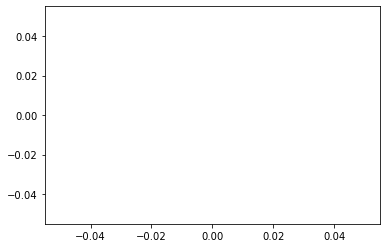

In [109]:
fig, ax = plt.subplots()


figura = ax.contourf(x_array[0:10], y_array[0:10], z_array[0:10])

#fig.colorbar(figura)

In [6]:
pd.concat([df['Track (m)']]*profundidades.shape[1], axis = 1).melt(value_name = 'distancia')

,variable,distancia
0,Track (m),0.02
1,Track (m),0.04
2,Track (m),0.06
3,Track (m),0.08
4,Track (m),0.09
...,...,...
22231,Track (m),110.63
22232,Track (m),110.67
22233,Track (m),110.71
22234,Track (m),110.74


In [7]:
df_variaveis_para_interpolar = pd.concat( [pd.concat([df['Track (m)']]*profundidades.shape[1], axis = 1).melt(value_name = 'distancia') , profundidades.melt(value_name = 'profundidade') , intensidade.melt(value_name = 'intensidade')], axis = 1 )

df_variaveis_para_interpolar.dropna(inplace =  True)

In [8]:
df_variaveis_para_interpolar['profundidade'] = -df_variaveis_para_interpolar['profundidade']

In [9]:
df_variaveis_para_interpolar

,variable,distancia,variable,profundidade,variable,intensidade
0,Track (m),0.02,Cell1 Location (m),-0.37,Cell1 Spd (m/s),0.022
1,Track (m),0.04,Cell1 Location (m),-0.37,Cell1 Spd (m/s),0.036
2,Track (m),0.06,Cell1 Location (m),-0.37,Cell1 Spd (m/s),0.040
3,Track (m),0.08,Cell1 Location (m),-0.37,Cell1 Spd (m/s),0.028
4,Track (m),0.09,Cell1 Location (m),-0.37,Cell1 Spd (m/s),0.031
...,...,...,...,...,...,...
20633,Track (m),1.57,Cell64 Location (m),-1.63,Cell64 Spd (m/s),0.032
20960,Track (m),1.57,Cell65 Location (m),-1.65,Cell65 Spd (m/s),0.074
21287,Track (m),1.57,Cell66 Location (m),-1.67,Cell66 Spd (m/s),0.068
21614,Track (m),1.57,Cell67 Location (m),-1.69,Cell67 Spd (m/s),0.123


In [158]:
#df_variaveis_para_interpolar.to_csv(r'E:\Usuário\Pablo\Documents\MEGAsync\Trabalhos hidrologia\vetores 3d\vetores_cataratas.csv')

In [10]:
#Interpolação Linear de velocidades
f = interp2d(df_variaveis_para_interpolar['distancia'].values , df_variaveis_para_interpolar['profundidade'].values , df_variaveis_para_interpolar['intensidade'].values,kind="linear")

E:\Programas\Conda\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=115,66 m=7196 fp=13.050439 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [12]:
x_coords = np.arange(min(df_variaveis_para_interpolar['distancia'].values),max(df_variaveis_para_interpolar['distancia'].values)+1)
y_coords = np.arange(min(df_variaveis_para_interpolar['profundidade'].values), max(df_variaveis_para_interpolar['profundidade'].values)+1)

In [13]:
y_coords = np.linspace(min(df_variaveis_para_interpolar['profundidade'].values), max(df_variaveis_para_interpolar['profundidade'].values)+1, 50)

In [149]:
Z = f(x_coords, y_coords)

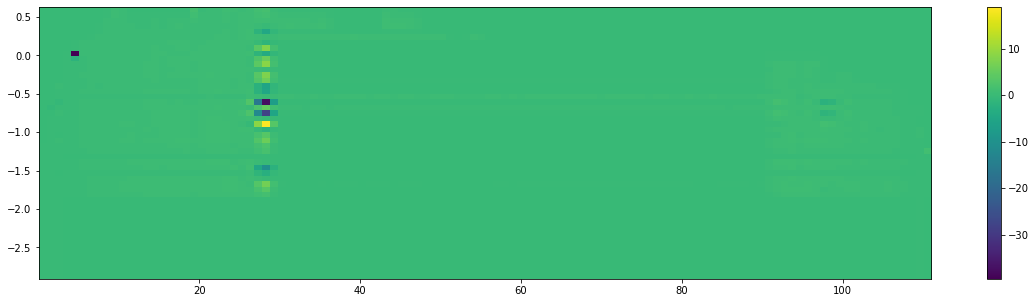

In [16]:



#cmap = plt.cm.get_cmap("jet")

plt.figure(figsize = (20, 5))
plt.imshow(Z, extent=[min(x_coords),max(x_coords),min(y_coords),max(y_coords)], aspect='auto')
plt.colorbar()

In [142]:
random.shape

(8, 90)

In [5]:
#função que calcula distância em relação as coordenadas.
sum_dist = 0
lista_distancias = [0]

for i, j in zip(range(len(utm_x)-1), range(1, len(utm_x))):
    
    delta_x = utm_x.iloc[i] -  utm_x.iloc[j]
    delta_y = utm_y.iloc[i] - utm_y.iloc[j]
    
    
    sum_dist +=  (delta_x**2 + delta_y**2)**(0.5)
    
    lista_distancias.append(sum_dist)
    
    
    

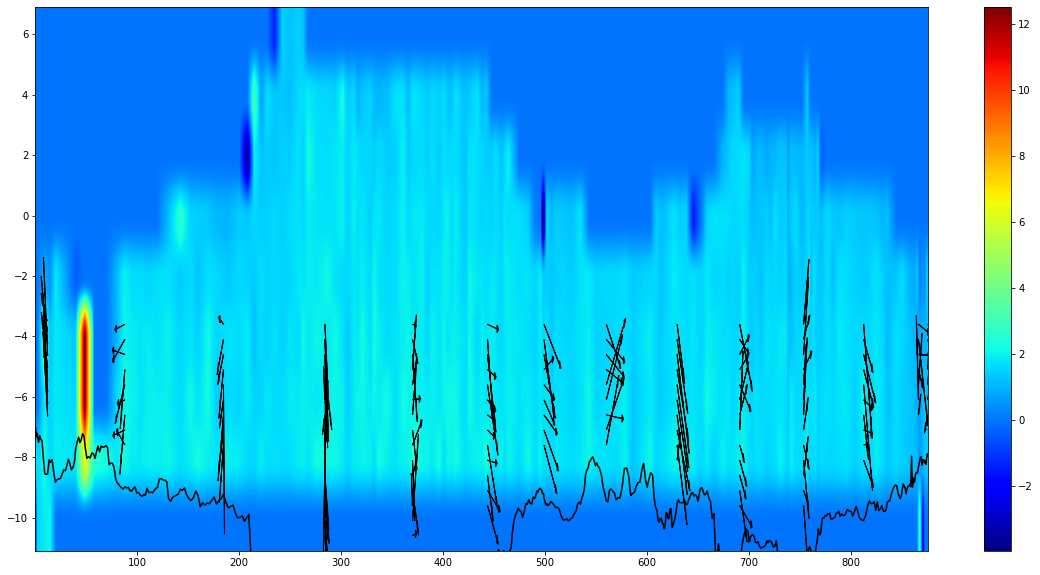

In [135]:
fig, ax = plt.subplots(figsize = (20, 10))

for colunas in utmy_matriz.T.iloc[:, 30:800:50].columns:
    
    
    for x, y, dx, dy in zip(distancias_matriz.T.iloc[:, colunas], profundidades.T.iloc[:, colunas], velocidade_x.T.iloc[:, colunas], velocidade_z.T.iloc[:, colunas]):
        
        if not math.isnan(y):
            
            #print(x, y, dx, dy)
            ax.arrow(x, -y, dx*15, dy*15, width = 0.0001 , head_width=0.25, head_length=1.5, fc='k', ec='k')
            
            
    
ax.plot(df['Track (m)'], -df['VB Depth (m)'], color = 'black')  
    

Z = f(x_coords, y_coords)

cmap = plt.cm.get_cmap("jet")


plt.imshow(Z, extent=[min(x_coords),max(x_coords),min(y_coords),max(y_coords)+10], aspect='auto', cmap = cmap)
plt.colorbar()  
    

<ipython-input-133-3f2998b4a248>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_array = np.array([


ValueError: setting an array element with a sequence.

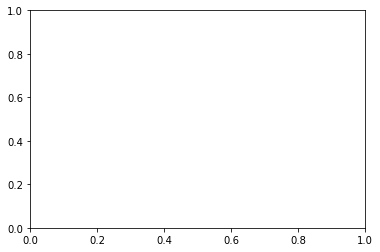

In [133]:
x_array = np.array([
    [1, 2, 3],
    [1, 2, 3],
    [1, 2, 3],
    [1, 2]
    
])

y_array = np.array([
    [1, 1, 3],
    [2, 5, 10],
    [3, 7, 14]
    
])

z_array = np.array([
    [0.5, 1, 1.5],
    [2, 2.5, 3],
    [3, 3.5, 4]
    
])

fig, ax = plt.subplots()


figura = ax.contourf(x_array, y_array, z_array, 100)

fig.colorbar(figura)

In [137]:
x_array_ = distancias_matriz.T.to_numpy()
y_array_= profundidades.T.to_numpy()  
z_array_ = intensidade.T.to_numpy()

In [129]:
inds = np.logical_not(np.isnan(x_array_) | np.isnan(y_array_) | np.isnan(z_array_))

In [158]:
x_array_[~np.isnan(x_array_)]

7196

TypeError: Input z must be 2D, not 1D

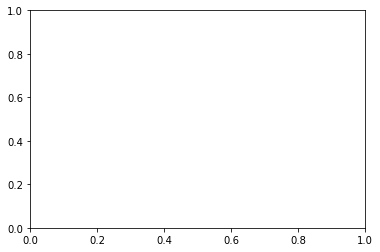

In [159]:
fig, ax = plt.subplots()


figura = ax.contourf(x_array_[0:8], -y_array_[0:8], z_array_[0:8], 100)

fig.colorbar(figura)



In [147]:
x_array_[8]

array([2.0000e-02, 4.0000e-02, 6.0000e-02, 8.0000e-02, 9.0000e-02,
       1.0000e-01, 1.1000e-01, 1.3000e-01, 1.5000e-01, 1.8000e-01,
       2.0000e-01, 2.2000e-01, 2.3000e-01, 2.4000e-01, 2.5000e-01,
       1.0000e-02, 2.0000e-02, 2.0000e-02, 4.0000e-02, 8.0000e-02,
       1.1000e-01, 2.0000e-01, 2.7000e-01, 3.7000e-01, 4.8000e-01,
       5.9000e-01, 7.5000e-01, 8.9000e-01, 1.0000e+00, 1.1500e+00,
       1.2800e+00, 1.4300e+00, 1.5700e+00, 1.7300e+00, 1.8900e+00,
       2.0400e+00, 2.2000e+00, 2.3600e+00, 2.5400e+00, 2.6900e+00,
       2.8500e+00, 3.0000e+00, 3.1700e+00, 3.3600e+00, 3.5800e+00,
       3.8100e+00, 4.0300e+00, 4.2500e+00, 4.4600e+00, 4.6900e+00,
       4.9500e+00, 5.2200e+00, 5.4400e+00, 5.6700e+00, 5.8800e+00,
       6.1100e+00, 6.3000e+00, 6.5000e+00, 6.7100e+00, 6.9200e+00,
       7.1500e+00, 7.4200e+00, 7.6900e+00, 7.9500e+00, 8.2100e+00,
       8.4700e+00, 8.7300e+00, 9.0500e+00, 9.3200e+00, 9.6300e+00,
       9.9200e+00, 1.0250e+01, 1.0570e+01, 1.0920e+01, 1.1260e